### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 100  # upper limit of integral # 5
nbit = 20  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.00032892188007938847
Discretized Result: 0.00032892188007927603


### Grover Operators for Amplitude Estimation

We can easily build quantum circuits for fast computation of the Monte Carlo integration as below. Here, we show functions to construct quantum circuits running with simulators. Running them on real devices should be easy by adjusting the parameters of the functions.  

In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  DeprecationWarning,


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *
from inv_s_scipy import InvSSciPy
from inv_s_scipy_sgs import InvSSciPySGS

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/qcstyle.py:340: UserWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


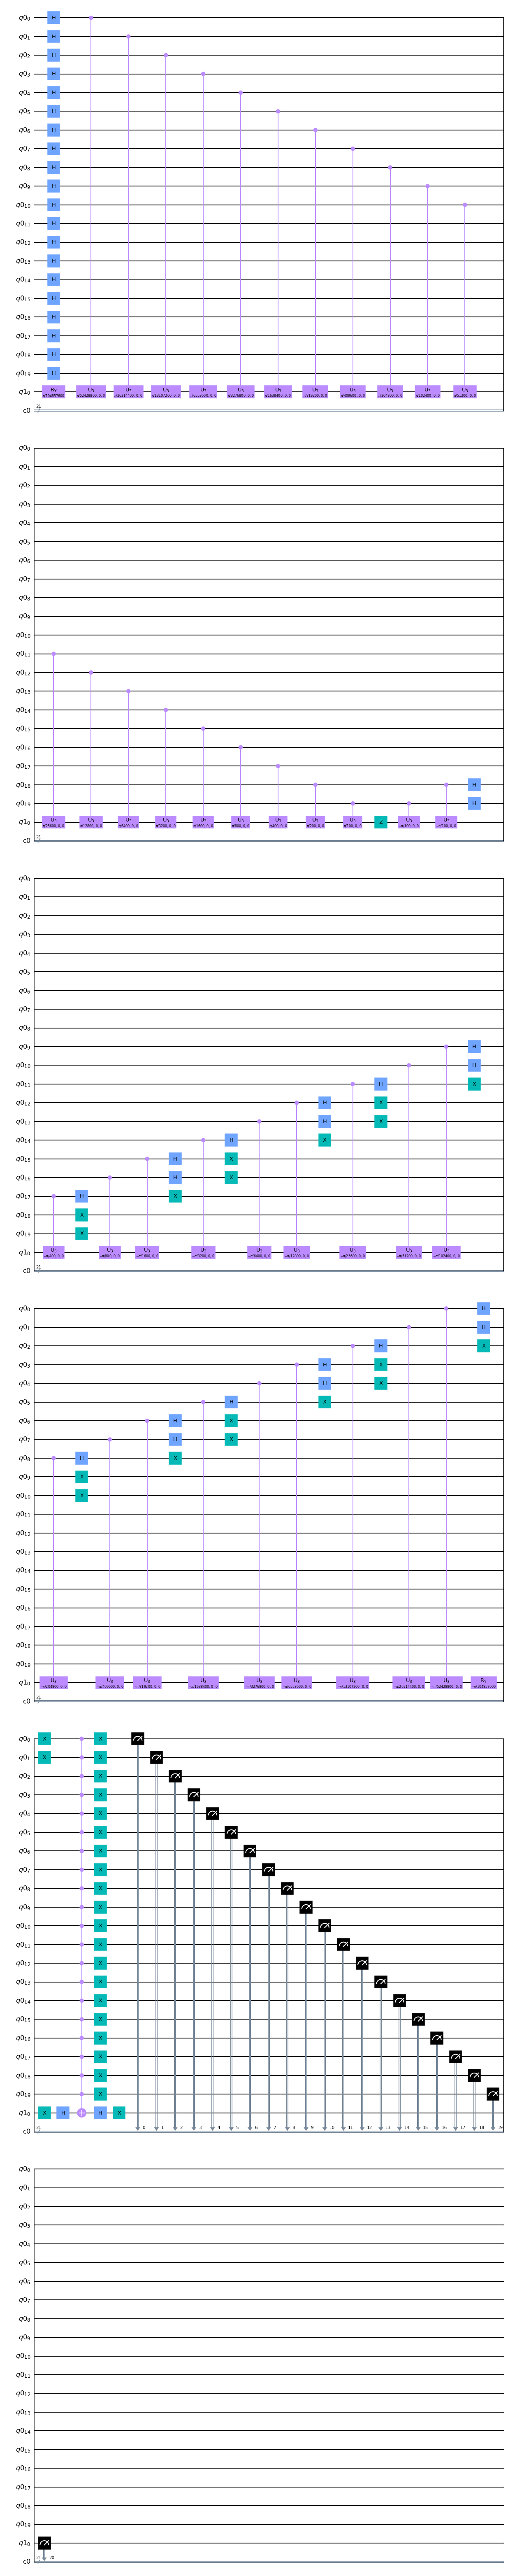

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.97, 0.03],[0.03,0.97]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [13]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.6773838996887207 s
1 th round with 1 oracles
0.16273808479309082 s
2 th round with 2 oracles
0.2792501449584961 s
3 th round with 3 oracles
0.3482320308685303 s
4 th round with 4 oracles
0.3869209289550781 s
5 th round with 5 oracles
0.5235271453857422 s
6 th round with 6 oracles
0.6204893589019775 s
7 th round with 7 oracles
0.6916241645812988 s
8 th round with 8 oracles
0.9079239368438721 s
9 th round with 9 oracles
1.1264629364013672 s
10 th round with 10 oracles
1.1798961162567139 s
11 th round with 11 oracles
1.658656120300293 s
12 th round with 12 oracles
1.5233070850372314 s
13 th round with 13 oracles
1.6147329807281494 s
14 th round with 14 oracles
1.5433411598205566 s
15 th round with 15 oracles
1.5536448955535889 s
16 th round with 16 oracles
1.7956719398498535 s
17 th round with 17 oracles
1.8481297492980957 s
18 th round with 18 oracles
2.035576820373535 s
19 th round with 19 oracles
2.1446189880371094 s
20 th round with 20 oracles
2.24543714523

In [14]:
import pickle
with open("raw_result_20_003_003.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_20_003_003.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[56, 46, 56, 46, 50, 41, 53, 55, 43, 46, 45, 38, 54, 42, 41, 43, 38, 36, 33, 23, 28, 41, 25, 35, 20, 17, 18, 20, 14, 12, 17, 12, 12, 11, 10, 7, 3, 6, 1, 0, 0, 1, 1, 3, 2, 1, 2, 4, 2, 6, 5, 5, 6, 9, 5, 11, 10, 14, 11, 21, 22, 23, 21, 21, 31, 34, 35, 27, 37, 25, 29, 42, 40, 51, 40, 41, 51, 47, 53, 47, 48, 50, 54, 55, 49, 52, 52, 54, 52, 42, 59, 48, 55, 50, 49, 48, 47, 51, 47, 43]


In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
ts_lm0_sgs = []
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list:
    t1 = time.time()
    x_tilde = meas_filter.apply(counts)
    t2 = time.time()
    ts_lm0_sgs.append(t2 - t1)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.3398978654848628
sum of mitigated probability vector x_hat_s: 1.3398978568343842
0.05073690414428711 s
number of positive values:  24
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.3758122874913334
sum of mitigated probability vector x_hat_s: 1.3758122614585149
0.07382583618164062 s
number of positive values:  27
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4106404164780968
sum of mitigated probability vector x_hat_s: 1.4106404191145474
0.04687809944152832 s
number of positive values:  22
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4247597382964097
sum of mitigated probability vector x_hat_s: 1.4247597335188071
0.0637056827545166 s
numb

sum of mitigated probability vector x_s: 1.5525119365349545
sum of mitigated probability vector x_hat_s: 1.5525118359116044
0.0682990550994873 s
number of positive values:  30
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.5778853079277497
sum of mitigated probability vector x_hat_s: 1.577885194991819
0.0627291202545166 s
number of positive values:  27
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.5586892698166352
sum of mitigated probability vector x_hat_s: 1.5586891448475302
0.07446694374084473 s
number of positive values:  31
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.4531894676727546
sum of mitigated probability vector x_hat_s: 1.4531893373341345
0.08778619766235352 s
number of positive values:  31
main process: Done!
Restriction to label

sum of mitigated probability vector x_s: 1.5445839993212056
sum of mitigated probability vector x_hat_s: 1.544583936688924
0.11397790908813477 s
number of positive values:  38
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.6327324033662785
sum of mitigated probability vector x_hat_s: 1.6327323500892121
0.0796358585357666 s
number of positive values:  37
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.5272619738139994
sum of mitigated probability vector x_hat_s: 1.5272619268381298
0.06823396682739258 s
number of positive values:  34
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.5232775343051392
sum of mitigated probability vector x_hat_s: 1.5232774974782994
0.052397966384887695 s
number of positive values:  22
main process: Done!
Restriction to lab

In [12]:
ts_mooney100 = []
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    t1 = time.time()
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    t2 = time.time()
    ts_mooney100.append(t2 - t1)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney100_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney100_list)

The heuristcs by Mooney et al. + SGS algorithm
{4097: 0.019458064152242296, 1032: 0.01890107034830403, 131136: 0.018767948332858785, 544: 0.01847680283845836, 10240: 0.0176545246779914, 24576: 0.01810228121485081, 1024: -0.01961438327410648, 131072: -0.014954232017926195, 262144: 0.0228768420277161, 40960: 0.017598313527953983, 16384: -0.014898604969738279, 65536: 0.024521767457831523, 8192: 0.022048135849107288, 1048576: 0.030343024333200578, 520: 0.01854723085924383, 272385: 0.019504641427652486, 172032: 0.01887176553524098, 32768: -0.013502825831659213, 67584: 0.01764622049294635, 0: 1.0700783666616318}
sum of counts: 1.3104269536438005
0.005307912826538086 s
number of positive values:  16
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{513: 0.01900219693827995, 131077: 0.019455529435681032, 24: 0.017129302955559454, 147456: 0.01728563598904206, 32832: 0.01757978417515884, 8224: 0.017836912406447393, 12288: 0.017212170466625112, 1114112: 0.017070844216031566, 524

{1056832: 0.018099107992176452, 1118208: 0.018134311887079816, 16384: 0.012230406527387903, 1056772: 0.018769222276933076, 1573120: 0.015375483632795563, 1589248: 0.014733778146985243, 131072: 0.031605766442013856, 96: 0.019445506438679837, 1048848: 0.01808578570108777, 1572993: 0.019511888398287422, 1576964: 0.019355128020289276, 1575040: 0.01885994977184185, 1573376: 0.015828691710077013, 1310720: 0.0605392963815186, 1048640: 0.02259410876162992, 1073152: 0.03832738606698245, 1056770: 0.01877446061189425, 0: 0.215618329411163, 1622016: 0.0191019480013575, 1057408: 0.019499406527532875, 1574912: 0.014844997142719831, 1114112: 0.02362329288854214, 1310848: 0.017040452936086033, 262144: 0.010196526447114267, 1343492: 0.01948953919410215, 1048577: 0.043087972475817, 1048587: 0.01963991563224042, 1048592: 0.021806149766750486, 1053056: 0.019426034708916566, 1085760: 0.019504422272372944, 1572864: 0.11593905577521686, 1048576: 0.4648409415821922, 1572872: 0.05489820162822023}
sum of counts

{1081344: 0.026363491765660302, 640: 0.018338161635879893, 32768: 0.019725997199785773, 1572864: 0.08513564752239601, 1605633: 0.019610380967151952, 128: 0.019609329668118396, 257: 0.018956910755409645, 1053184: 0.018958371605120934, 1064960: 0.026290624008288528, 66048: 0.019521572753207286, 1836288: 0.01940620845185567, 1049856: 0.018821844953095378, 1114368: 0.019501921034816898, 4104: 0.01893463665671156, 1048640: 0.02505774643617363, 1310720: 0.08404439261614821, 1122304: 0.019406401897234634, 262208: 0.018789514607704793, 49168: 0.019462724358494648, 36: 0.018776846553732133, 1048576: 0.3812156599099688, 64: 0.017862875660452495, 40960: 0.01825677361659137, 0: 0.584286788908685}
sum of counts: 1.536334823542684
0.0070879459381103516 s
number of positive values:  24
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1028: 0.0193039025833373, 1048592: 0.028274740292626662, 131073: 0.018878280162524005, 524288: 0.01537067987912144, 1048640: 0.04827002959704196, 6553

{18436: 0.01947006296561943, 72: 0.017340630524125253, 1573376: 0.019568180651876405, 131072: 0.04718493377816308, 65544: 0.01635050171889142, 4: 0.02610457158457874, 1146880: 0.019514169959977904, 0: 0.9501009882978696, 2081: 0.019570979461337918, 524304: 0.018700380744811725, 1048578: 0.019462562011211115, 8: 0.04907920401461136, 262144: -0.011971179123939498, 1152: 0.016311501030336177, 1572868: 0.019425847273481713, 1179648: 0.018199266816040418, 1024: 0.06208169494643486, 132128: 0.019330667574075124, 65536: 0.028214041000204127}
sum of counts: 1.374039005229707
0.00565028190612793 s
number of positive values:  18
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{262146: 0.019425945288803367, 8448: 0.019460361711886736, 1114112: 0.013538396315324525, 68096: 0.01897984867946016, 524356: 0.01937953418031586, 1572872: 0.019115893327718143, 16384: 0.048336913828518326, 524296: 0.016806660159417414, 524288: 0.04846751394944405, 32: 0.0315526446459525, 4096: 0.02791469

In [13]:
ts_mooney10 = []
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    t1 = time.time()
    x_tilde = meas_filter.apply(counts, threshold=1/10)
    t2 = time.time()
    ts_mooney10.append(t2 - t1)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney10_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney10_list)

The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0879653191096026}
sum of counts: 1.0879653191096026
0.0010039806365966797 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.8941349056055774}
sum of counts: 0.8941349056055774
0.0006299018859863281 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 1.0886639311893418}
sum of counts: 1.0886639311893418
0.0006148815155029297 s
number of positive values:  1
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.8941349056055774}
sum of counts: 0.8941349056055774
0.0013859272003173828 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{0: 0.9712479037593431}
sum of counts: 0.9712479037593431
0.0016772747039794922 s

{1048576: 0.5057737743325313}
sum of counts: 0.5057737743325313
0.0023391246795654297 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1048576: 0.837629002547833}
sum of counts: 0.837629002547833
0.0010399818420410156 s
number of positive values:  1
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1572864: 0.25104824132937265, 1048576: 0.6736165200339603}
sum of counts: 0.924664761363333
0.0008862018585205078 s
number of positive values:  2
accumulator is positive, we might even ignoring the necessal positive values.
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1048576: 0.8688851795700021, 1572864: 0.2061777829427463}
sum of counts: 1.0750629625127484
0.0007460117340087891 s
number of positive values:  2
main process: Done!
The heuristcs by 

In [14]:
ts_scipy = []
meas_filter = InvSSciPy(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_SciPy_list = []
for counts in counts_list:
    t1 = time.time()
    x_tilde = meas_filter.apply(counts)
    t2 = time.time()
    ts_scipy.append(t2 - t1)
    x_tilde_S_SciPy_list.append(x_tilde)
mit_hit_S_SciPy_list = make_hit_list(x_tilde_S_SciPy_list)
print(mit_hit_S_SciPy_list)

Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.3398978654848628
sum of mitigated probability vector x_tilde: 1.0000000000000018
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.3758122874913334
sum of mitigated probability vector x_tilde: 1.0000000000000002
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.4106404164780968
sum of mitigated probability vector x_tilde: 1.0000000000000029
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.4247597382964097
sum of mitigated probability vector x_tilde: 0.9999999999999998
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.4072731368362617
sum of mitigated probability vector x_tilde: 1.0
main process: Done!
Restriction to labels of 

sum of mitigated probability vector x_s: 1.4092121029956892
sum of mitigated probability vector x_tilde: 1.0000000000000002
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.487242966679283
sum of mitigated probability vector x_tilde: 1.0
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.4556729322964352
sum of mitigated probability vector x_tilde: 1.0000000000000004
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.4678858608247172
sum of mitigated probability vector x_tilde: 1.0
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.5578003542019245
sum of mitigated probability vector x_tilde: 0.9999999999999999
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 

sum of mitigated probability vector x_s: 1.4604690334747585
sum of mitigated probability vector x_tilde: 1.0000000000000004
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.3798054681773568
sum of mitigated probability vector x_tilde: 1.0000000000000002
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.4869541881303276
sum of mitigated probability vector x_tilde: 1.0
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.3449943547486654
sum of mitigated probability vector x_tilde: 1.0000000000000016
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probability vector x_s: 1.467324035530342
sum of mitigated probability vector x_tilde: 1.0000000000000004
main process: Done!
Restriction to labels of y + whole SciPy optimization
sum of mitigated probabili

In [15]:
ts_scipy_sgs = []
meas_filter = InvSSciPySGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_SciPy_SGS_list = []
for counts in counts_list:
    t1 = time.time()
    x_tilde = meas_filter.apply(counts)
    t2 = time.time()
    ts_scipy_sgs.append(t2 - t1)
    x_tilde_S_SciPy_SGS_list.append(x_tilde)
mit_hit_S_SciPy_SGS_list = make_hit_list(x_tilde_S_SciPy_SGS_list)
print(mit_hit_S_SciPy_SGS_list)

Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.3398978654848628
sum of mitigated probability vector x_tilde: 0.9999999999999982
number of positive values:  17
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.3758122874913334
sum of mitigated probability vector x_tilde: 1.0000000000000013
number of positive values:  24
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.4106404164780968
sum of mitigated probability vector x_tilde: 1.0
number of positive values:  20
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.4247597382964097
sum of mitigated probability vector x_tilde: 0.9999999999999987
number of positive values:  24
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algor

sum of mitigated probability vector x_s: 1.4531894676727546
sum of mitigated probability vector x_tilde: 1.0000000000000004
number of positive values:  26
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.4310318463478229
sum of mitigated probability vector x_tilde: 1.0000000000000002
number of positive values:  30
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.424606678384994
sum of mitigated probability vector x_tilde: 0.9999999999999996
number of positive values:  31
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.4440923954831275
sum of mitigated probability vector x_tilde: 1.0000000000000002
number of positive values:  32
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.49

sum of mitigated probability vector x_s: 1.3372466598463741
sum of mitigated probability vector x_tilde: 0.9999999999999984
number of positive values:  19
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.5656615267963994
sum of mitigated probability vector x_tilde: 1.000000000000001
number of positive values:  17
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.492329852682303
sum of mitigated probability vector x_tilde: 0.9999999999999994
number of positive values:  33
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.4664180017148447
sum of mitigated probability vector x_tilde: 0.9999999999999998
number of positive values:  25
main process: Done!
Restriction to labels of y + SciPy optimization + SGS algorithm
sum of mitigated probability vector x_s: 1.376

In [20]:
import pickle
with open("hit_list_20_003_003.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [21]:
# import pickle
# with open("mit_hit_S_list_20_003_003.pkl", "wb")as f:
#     pickle.dump(mit_hit_S_list, f)

In [13]:
import pickle
with open("mit_hit_S_lm_0_list_20_003_003.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [14]:
import pickle
with open("mit_hit_mooney100_list_20_003_003.pkl", "wb") as f:
    pickle.dump(mit_hit_mooney_list, f)

In [23]:
with open("hit_list_20_003_003.pkl", "rb") as f:
    hit_list = pickle.load(f)
with open("mit_hit_S_lm_0_list_20_003_003.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)
with open("mit_hit_mooney100_list_20_003_003.pkl", "rb") as f:
    mit_hit_mooney_list = pickle.load(f)

Text(0, 0.5, 'number of shots for $|00...0>$')

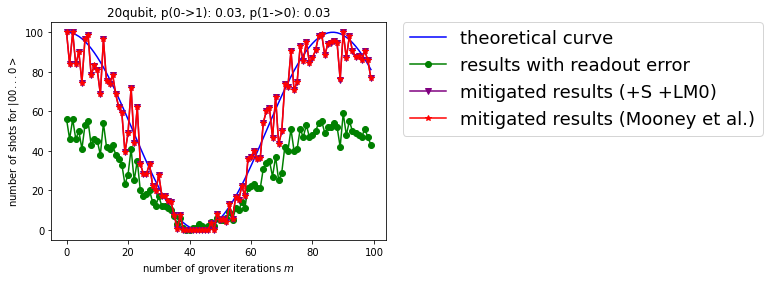

In [15]:
divide = 100
number_grover_list = [i for i in range(100)]
plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="*", label="mitigated results (Mooney et al.)", color="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("20qubit, p(0->1): 0.03, p(1->0): 0.03")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [16]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney100_list = [100 - h for h in mit_hit_mooney100_list]
sin_mit_hit_mooney10_list = [100 - h for h in mit_hit_mooney10_list]
sin_mit_hit_S_SciPy_list = [100 - h for h in mit_hit_S_SciPy_list]
sin_mit_hit_S_SciPy_SGS_list = [100 - h for h in mit_hit_S_SciPy_SGS_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney100_list = calculate_theta(
    sin_mit_hit_mooney100_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney10_list = calculate_theta(
    sin_mit_hit_mooney10_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_SciPy_list = calculate_theta(
    sin_mit_hit_S_SciPy_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_SciPy_SGS_list = calculate_theta(
    sin_mit_hit_S_SciPy_SGS_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney100_list = np.abs(np.sin(thetaCandidate_mit_mooney100_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney10_list = np.abs(np.sin(thetaCandidate_mit_mooney10_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_SciPy_list = np.abs(np.sin(thetaCandidate_mit_S_SciPy_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_SciPy_SGS_list = np.abs(np.sin(thetaCandidate_mit_S_SciPy_SGS_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

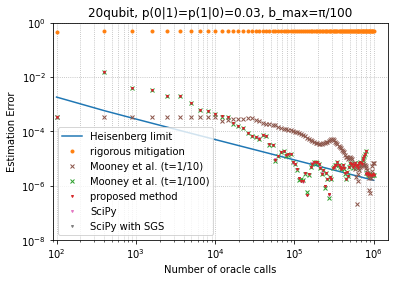

In [19]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney100_list, 'x', color='C2', markersize=4)
p4 = plt.loglog( OracleCall_list, error_mit_mooney10_list, 'x', color='C5', markersize=4)
p5 = plt.loglog( OracleCall_list, error_mit_S_SciPy_list, 'v', color='C6', markersize=2)
p6 = plt.loglog( OracleCall_list, error_mit_S_SciPy_SGS_list, 'v', color='C7', markersize=2)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("20qubit, p(0|1)=p(1|0)=0.03, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p4[0], p2[0], p3[0], p5[0], p6[0]), 
           ("Heisenberg limit", "rigorous mitigation", "Mooney et al. (t=1/10)", "Mooney et al. (t=1/100)", "proposed method", "SciPy", "SciPy with SGS"))
plt.show()

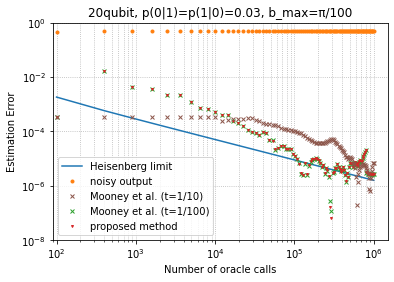

In [16]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney100_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)
p4 = plt.loglog( OracleCall_list, error_mit_mooney10_list, 'x', color='C5', markersize=4)

plt.title("20qubit, p(0|1)=p(1|0)=0.03, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p4[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "Mooney et al. (t=1/10)", "Mooney et al. (t=1/100)", "proposed method"))
plt.show()

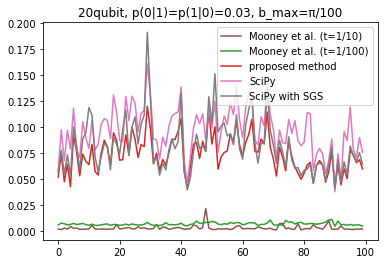

In [21]:
plt.clf()
p4 = plt.plot(ts_mooney10, color="C5")
p2 = plt.plot(ts_mooney100, color="C2")
p3 = plt.plot(ts_lm0_sgs, color="C3")
p5 = plt.plot(ts_scipy, color="C6")
p6 = plt.plot(ts_scipy_sgs, color="C7")
plt.title("20qubit, p(0|1)=p(1|0)=0.03, b_max=π/100")
plt.legend((p4[0], p2[0], p3[0], p5[0], p6[0]),
           ("Mooney et al. (t=1/10)", "Mooney et al. (t=1/100)", "proposed method", "SciPy", "SciPy with SGS"))
plt.show()